In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

drive/


In [ ]:
# XML TO YOLO CONV.


from pathlib import Path
from shutil import copy2
import xml.etree.ElementTree as ET
import random


# Custom paths for your Google Drive dataset
RAW_IMAGES_ROOT = Path("/content/drive/MyDrive/PCB/PCB_DATASET/images")
RAW_ANN_ROOT    = Path("/content/drive/MyDrive/PCB/PCB_DATASET/Annotations")


# Output folder (change to the desired folder for YOLO format)
OUT_DIR = Path("drive/MyDrive/PCB_YOLO_DATASET")


TRAIN_SPLIT = 0.8  # 80% train, 20% val

# Classes – MUST match the <name> tag inside your XMLs
CLASSES = [
    "missing_hole",
    "mouse_bite",
    "open_circuit",
    "short",
    "spur",
    "spurious_copper",
]


def voc_to_yolo_bbox(bbox, img_w, img_h):
    """
    VOC bbox: (xmin, ymin, xmax, ymax)
    return YOLO: x_center, y_center, w, h (normalized 0–1)
    """
    xmin, ymin, xmax, ymax = bbox
    x_center = (xmin + xmax) / 2.0 / img_w
    y_center = (ymin + ymax) / 2.0 / img_h
    w = (xmax - xmin) / img_w
    h = (ymax - ymin) / img_h
    return x_center, y_center, w, h

def parse_xml(xml_path: Path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    size = root.find("size")
    img_w = int(size.find("width").text)
    img_h = int(size.find("height").text)

    labels = []
    for obj in root.findall("object"):
        cls_name = obj.find("name").text
        if cls_name not in CLASSES:
            print(f"[WARN] Class '{cls_name}' not in CLASSES list, skipping.")
            continue
        cls_id = CLASSES.index(cls_name)

        bndbox = obj.find("bndbox")
        xmin = float(bndbox.find("xmin").text)
        ymin = float(bndbox.find("ymin").text)
        xmax = float(bndbox.find("xmax").text)
        ymax = float(bndbox.find("ymax").text)

        x_c, y_c, w, h = voc_to_yolo_bbox((xmin, ymin, xmax, ymax), img_w, img_h)
        labels.append((cls_id, x_c, y_c, w, h))

    return labels

def collect_all_samples():
    """Go through each class folder and collect (img_path, xml_path) pairs."""
    samples = []
    img_exts = [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".JPG", ".JPEG", ".PNG"]

    for cls in CLASSES:
        img_dir = RAW_IMAGES_ROOT / cls
        ann_dir = RAW_ANN_ROOT / cls

        if not img_dir.exists() or not ann_dir.exists():
            print(f"[WARN] Missing folder for class {cls}: {img_dir} or {ann_dir}")
            continue

        for img_path in img_dir.iterdir():
            if img_path.suffix not in img_exts:
                continue

            xml_path = ann_dir / (img_path.stem + ".xml")
            if not xml_path.exists():
                print(f"[WARN] No XML for {img_path}, expected {xml_path}")
                continue

            samples.append((img_path, xml_path))

    return samples

def main():
    samples = collect_all_samples()
    print(f"Found {len(samples)} image-annotation pairs in total.")

    if not samples:
        print("No data found. Check folder names and CLASSES list.")
        return

    random.shuffle(samples)
    n_train = int(len(samples) * TRAIN_SPLIT)
    train_samples = samples[:n_train]
    val_samples = samples[n_train:]

    # Create output directories
    for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
        (OUT_DIR / sub).mkdir(parents=True, exist_ok=True)

    def process_split(sample_list, split_name):
        for img_path, xml_path in sample_list:
            labels = parse_xml(xml_path)
            if not labels:
                print(f"[INFO] No valid objects in {xml_path.name}, skipping.")
                continue

            # Copy image
            out_img = OUT_DIR / "images" / split_name / img_path.name
            copy2(img_path, out_img)

            # Write label file
            out_lbl = OUT_DIR / "labels" / split_name / (img_path.stem + ".txt")
            with open(out_lbl, "w") as f:
                for cls_id, x_c, y_c, w, h in labels:
                    f.write(f"{cls_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}\n")

    print("Processing TRAIN...")
    process_split(train_samples, "train")
    print("Processing VAL...")
    process_split(val_samples, "val")

    print("Done! YOLO-format data is in:", OUT_DIR)

if __name__ == "__main__":
    main()

Found 693 image-annotation pairs in total.
Processing TRAIN...
Processing VAL...
Done! YOLO-format data is in: drive/MyDrive/PCB_YOLO_DATASET


In [ ]:
# DATA.YAML FILE CREATION

from pathlib import Path
import yaml  # pip install pyyaml if needed

OUT_DIR = Path("/content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET")
CLASSES = ["missing_hole", "mouse_bite", "open_circuit", "short", "spur", "spurious_copper"]

data = {
    "path": str(OUT_DIR),
    "train": "images/train",
    "val": "images/val",
    "nc": len(CLASSES),
    "names": CLASSES
}

with open(OUT_DIR / "data.yaml", "w") as f:
    yaml.dump(data, f)

print("data.yaml created at", OUT_DIR / "data.yaml")



data.yaml created at /content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET/data.yaml


In [ ]:
ls

drive/  sample_data/


In [ ]:

# Pip install method

!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.1/112.6 GB disk)


In [ ]:
from ultralytics import YOLO

from IPython.display import display, Image

In [ ]:
import torch
torch.cuda.is_available()


True

In [ ]:
cd /content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET

/content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET


In [ ]:
ls

data.yaml  images/  labels/  runs/  test/  yolo11n.pt


In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data=/content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET/data.yaml batch=8 epochs=10 imgsz=640 plots=True

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True,

In [ ]:
!yolo task=detect mode=train model=runs/detect/train/weights/last.pt data= data.yaml batch=8 epochs=10 imgsz=640 plots=True name=train_continued

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/train/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_continued, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots

In [ ]:
!yolo task=detect mode=train model=runs/detect/train_continued/weights/last.pt data= data.yaml batch=8 epochs=10 imgsz=640 plots=True name=train_continued1

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/train_continued/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_continued1, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective

In [ ]:
!yolo task=detect mode=train model=runs/detect/train_continued1/weights/last.pt data= data.yaml batch=8 epochs=20 imgsz=640 plots=True name=train_continued2

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/train_continued1/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_continued2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

In [ ]:
!yolo task=detect mode=train model=runs/detect/train_continued2/weights/last.pt data= data.yaml batch=8 epochs=20 imgsz=640 plots=True name=train_continued3

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/train_continued2/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_continued3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

In [ ]:
!yolo task=detect mode=train \
model=runs/detect/train_continued3/weights/last.pt \
data=data.yaml \
epochs=50 \
batch=4 \
imgsz=640 \
lr0=0.001 lrf=0.01 momentum=0.937 weight_decay=0.0005 \
optimizer=SGD cos_lr=True \
hsv_h=0.015 hsv_s=0.7 hsv_v=0.4 \
mosaic=1.0 mixup=0.10 \
degrees=2 translate=0.10 scale=0.40 shear=1 \
perspective=0.0003 \
patience=30 \
amp=True \
plots=True name=train_continued4


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=data.yaml, degrees=2, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=runs/detect/train_continued3/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_continued4, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=30, perspective=0.

In [ ]:
!yolo task=detect mode=train model=runs/detect/train_continued4/weights/last.pt data= data.yaml batch=8 epochs=20 imgsz=640 plots=True name=train_continued5

In [ ]:
!yolo task=detect mode=val model=runs/detect/train_continued3/weights/best.pt data=data.yaml

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 1.9±2.8 ms, read: 172.8±149.1 MB/s, size: 1227.1 KB)
val: Scanning /content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET/labels/val.cache... 139 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 139/139 1.7Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 9/9 1.1s/it 9.6s
                   all        139        585      0.961      0.914      0.942      0.495
          missing_hole         21         82      0.978      0.988       0.99      0.616
            mouse_bite         25        113       0.96      0.912      0.951      0.445
          open_circuit         22         88          1      0.924      0.979      0.482
                 short         22         91      0.967      0.956      0.971        0.

In [ ]:
cd drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET

/content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET


In [ ]:
ls

data.yaml  images/  labels/  runs/  test/  yolo11n.pt


In [ ]:
!yolo task=detect mode=predict model=runs/detect/train_continued3/weights/best.pt conf=0.25 source=test/images

Ultralytics 8.3.234 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs

image 1/1068 /content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET/test/images/l_light_01_missing_hole_04_2_600.jpg: 640x640 2 missing_holes, 907.2ms
image 2/1068 /content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET/test/images/l_light_01_missing_hole_07_2_600.jpg: 640x640 2 missing_holes, 664.9ms
image 3/1068 /content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET/test/images/l_light_01_missing_hole_08_1_600.jpg: 640x640 1 missing_hole, 618.2ms
image 4/1068 /content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET/test/images/l_light_01_missing_hole_10_2_600.jpg: 640x640 2 missing_holes, 670.5ms
image 5/1068 /content/drive/MyDrive/PCB/PCB_DATASET/drive/MyDrive/PCB_YOLO_DATASET/test/images/l_light_01_missing_hole_14_4_600.jpg: 640x640 1 missing_hole, 867.5ms
ima

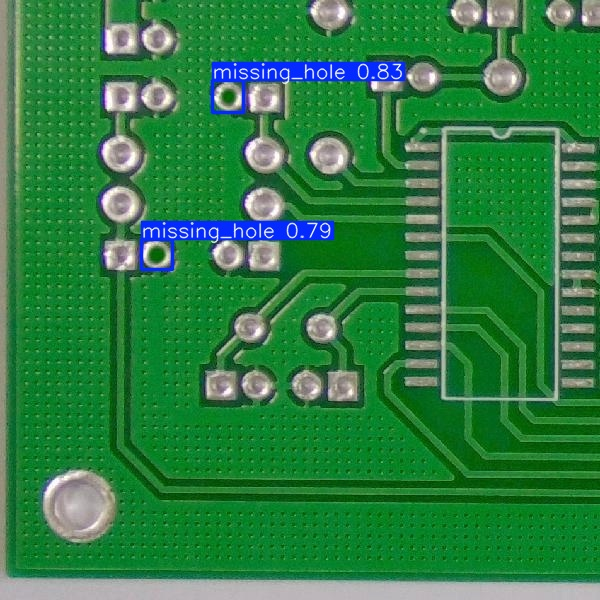

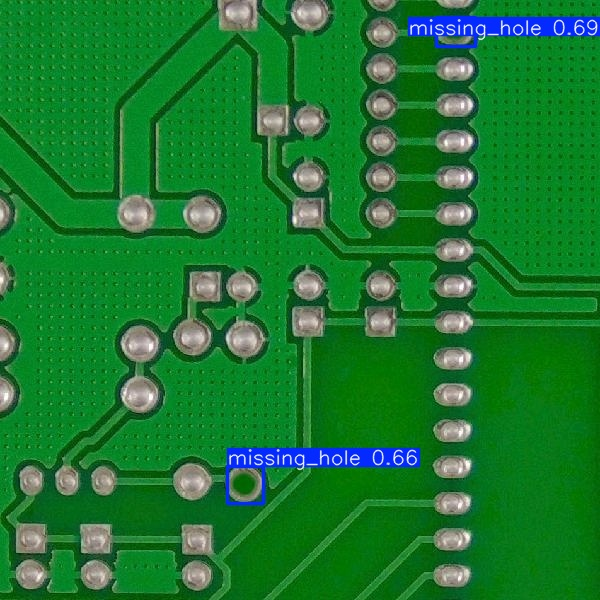

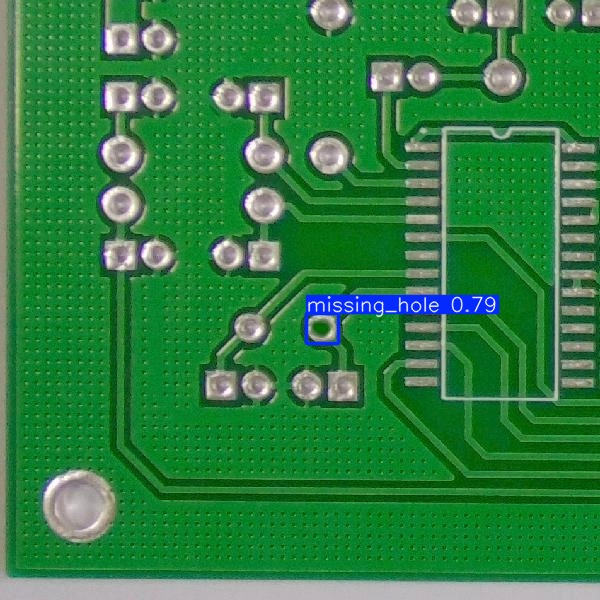

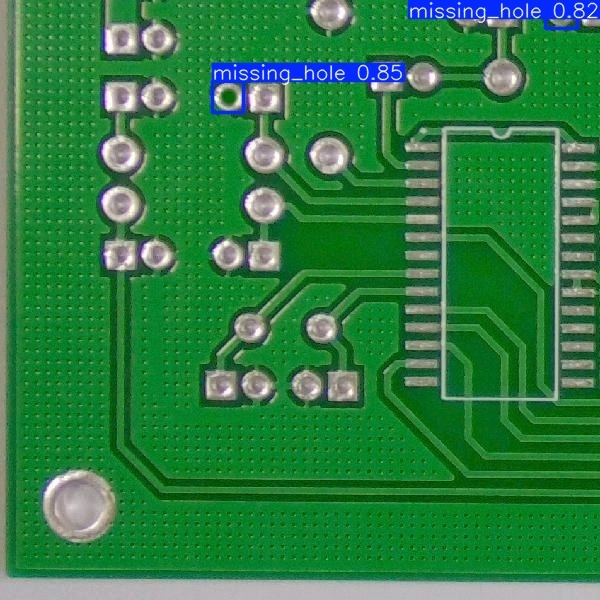

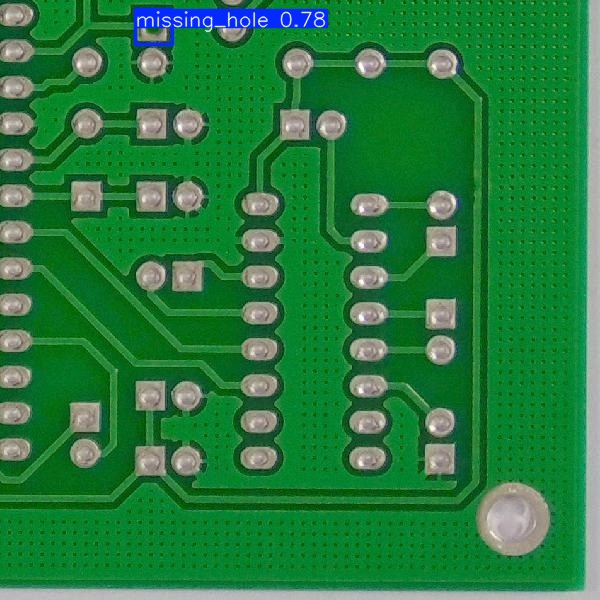

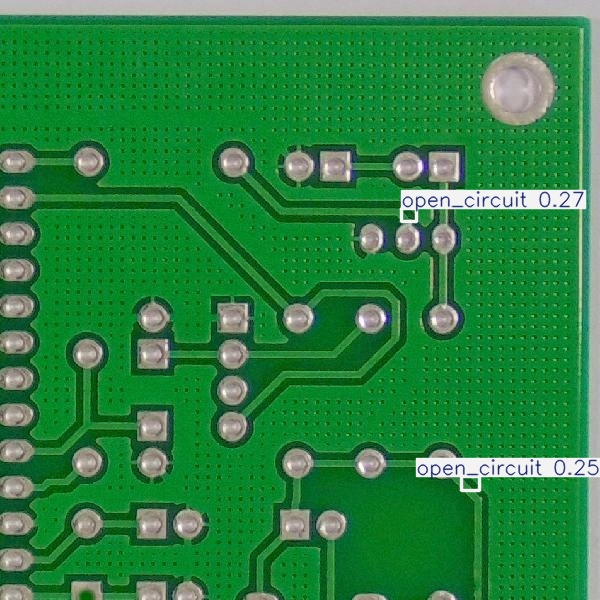

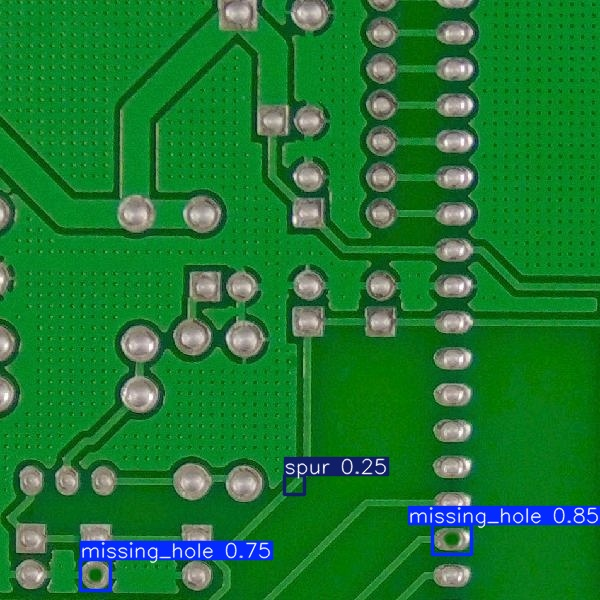

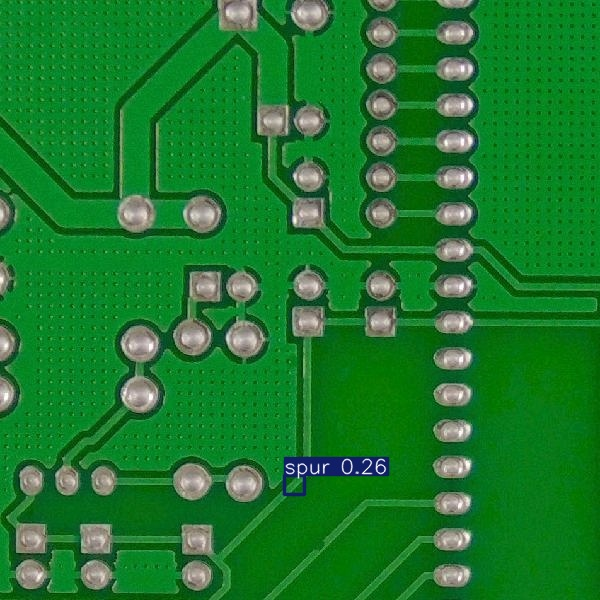

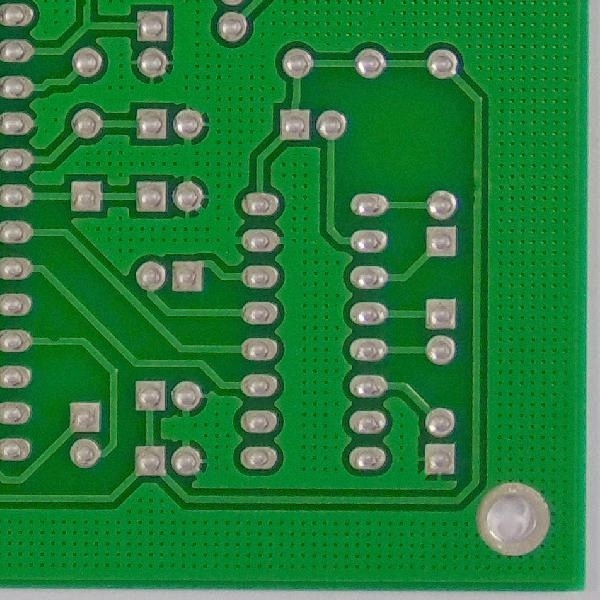

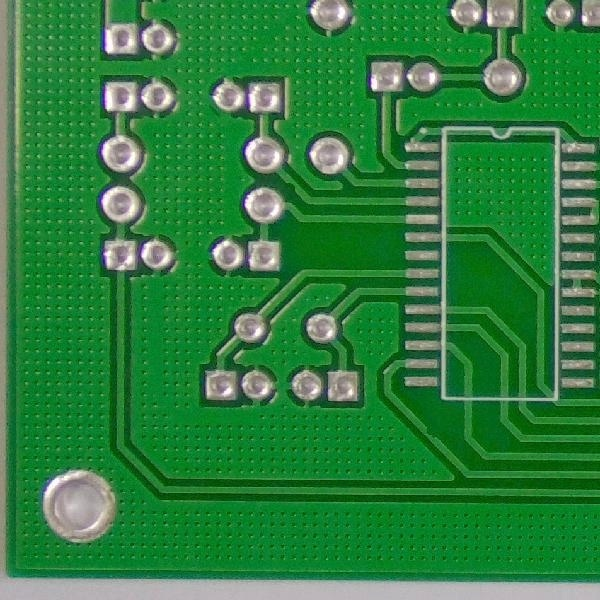

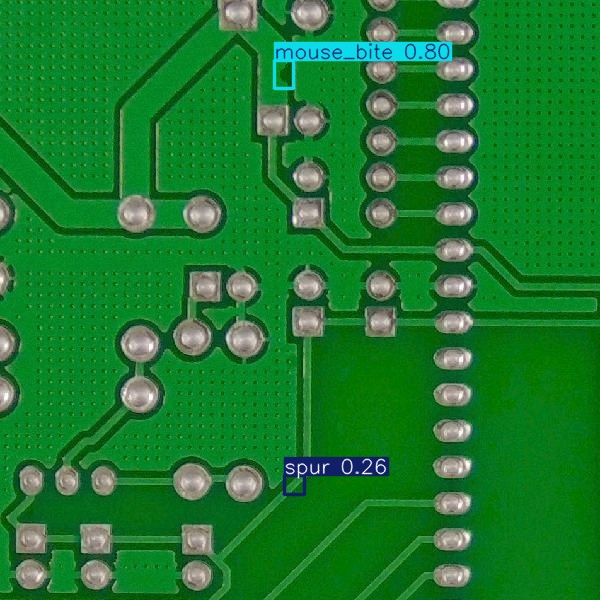

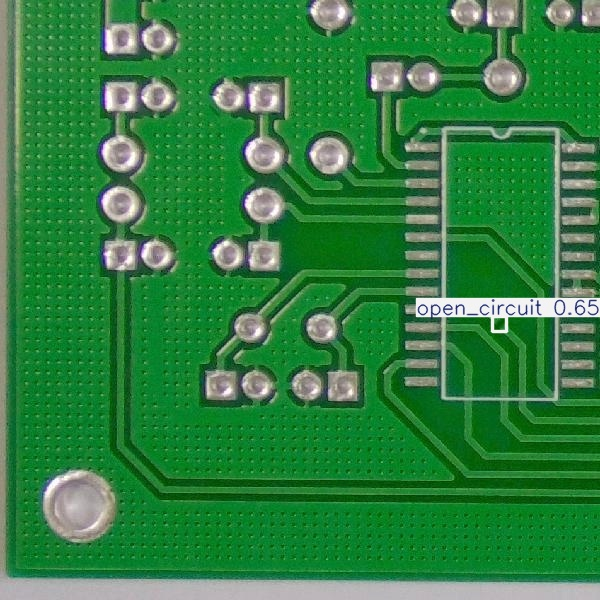

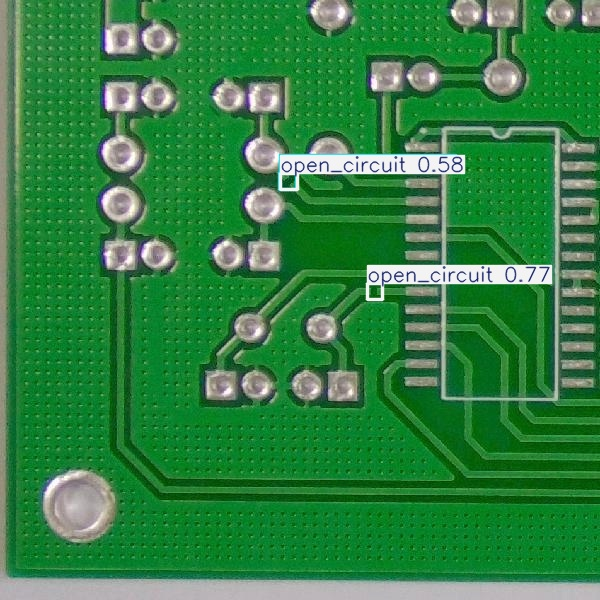

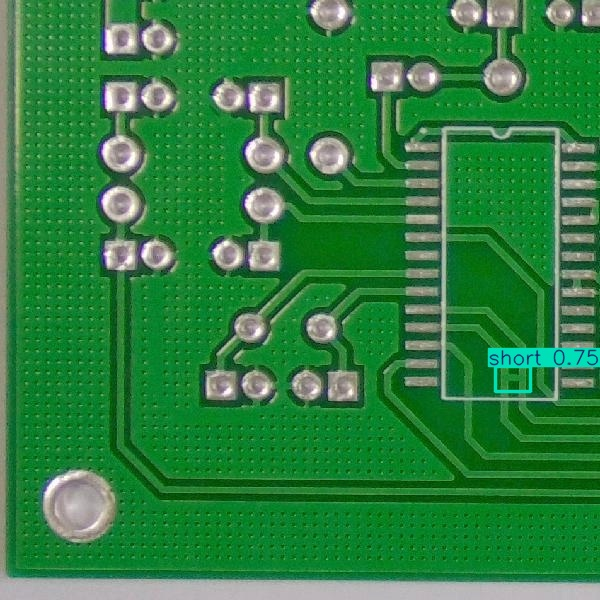

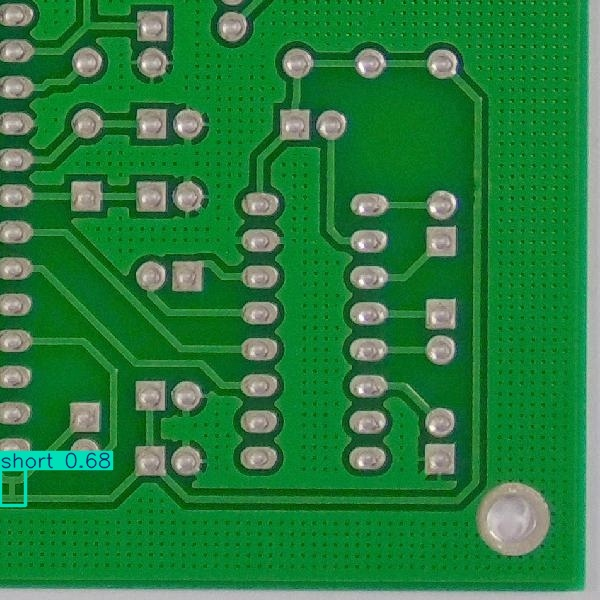

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob('runs/detect/predict/*.jpg')[:15]:
      display(Image(filename=image_path, width=600))
      print("\n")